using KMeans clustering on the IRIS dataset

In [1]:
# run on DataBricks
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
spark = SparkSession.builder.appName('K_means').getOrCreate()
df = spark.read.csv('IRIS.csv', inferSchema=True, header=True, sep=',')
df.show(5)

+---+---+---+---+-----------+
|  1|  2|  3|  4|          5|
+---+---+---+---+-----------+
|5.1|3.5|1.4|0.2|Iris-setosa|
|4.9|3.0|1.4|0.2|Iris-setosa|
|4.7|3.2|1.3|0.2|Iris-setosa|
|4.6|3.1|1.5|0.2|Iris-setosa|
|5.0|3.6|1.4|0.2|Iris-setosa|
+---+---+---+---+-----------+
only showing top 5 rows



In [4]:
df.printSchema()

root
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)
 |-- 5: string (nullable = true)



In [6]:
df.orderBy(F.rand()).show(10, False)

+---+---+---+---+---------------+
|1  |2  |3  |4  |5              |
+---+---+---+---+---------------+
|5.1|3.5|1.4|0.2|Iris-setosa    |
|5.7|2.6|3.5|1.0|Iris-versicolor|
|5.7|2.8|4.1|1.3|Iris-versicolor|
|5.8|2.7|3.9|1.2|Iris-versicolor|
|5.1|3.8|1.9|0.4|Iris-setosa    |
|5.7|3.0|4.2|1.2|Iris-versicolor|
|6.0|2.7|5.1|1.6|Iris-versicolor|
|4.8|3.0|1.4|0.3|Iris-setosa    |
|6.0|2.2|5.0|1.5|Iris-virginica |
|5.8|2.7|5.1|1.9|Iris-virginica |
+---+---+---+---+---------------+
only showing top 10 rows



In [7]:
df.groupBy('5').count().orderBy('count').show(10, False)

+---------------+-----+
|5              |count|
+---------------+-----+
|Iris-virginica |50   |
|Iris-versicolor|50   |
|Iris-setosa    |50   |
+---------------+-----+



In [10]:
input_cols = ['1', '2', '3', '4']
vec_assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
final_data = vec_assembler.transform(df)
final_data.show(10, False)

+---+---+---+---+-----------+-----------------+
|1  |2  |3  |4  |5          |features         |
+---+---+---+---+-----------+-----------------+
|5.1|3.5|1.4|0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|
|4.9|3.0|1.4|0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|
|4.7|3.2|1.3|0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|
|4.6|3.1|1.5|0.2|Iris-setosa|[4.6,3.1,1.5,0.2]|
|5.0|3.6|1.4|0.2|Iris-setosa|[5.0,3.6,1.4,0.2]|
|5.4|3.9|1.7|0.4|Iris-setosa|[5.4,3.9,1.7,0.4]|
|4.6|3.4|1.4|0.3|Iris-setosa|[4.6,3.4,1.4,0.3]|
|5.0|3.4|1.5|0.2|Iris-setosa|[5.0,3.4,1.5,0.2]|
|4.4|2.9|1.4|0.2|Iris-setosa|[4.4,2.9,1.4,0.2]|
|4.9|3.1|1.5|0.1|Iris-setosa|[4.9,3.1,1.5,0.1]|
+---+---+---+---+-----------+-----------------+
only showing top 10 rows



In [12]:
errors = []
for k in range(2, 10):
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(final_data)
    intra_distance = model.summary.trainingCost
    errors.append(intra_distance)
    print("With K={}".format(k))
    print("Within Set Sum of Squared Errors = " + str(intra_distance))
    print('--'*30)



With K=2
Within Set Sum of Squared Errors = 152.36870647733915
------------------------------------------------------------
With K=3
Within Set Sum of Squared Errors = 78.94084142614598
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 57.317873214285726
------------------------------------------------------------
With K=5
Within Set Sum of Squared Errors = 49.75817673992673
------------------------------------------------------------
With K=6
Within Set Sum of Squared Errors = 42.33477155507329
------------------------------------------------------------
With K=7
Within Set Sum of Squared Errors = 34.254373374210346
------------------------------------------------------------
With K=8
Within Set Sum of Squared Errors = 39.25592649900538
------------------------------------------------------------
With K=9
Within Set Sum of Squared Errors = 35.52746837606837
------------------------------------------------------------


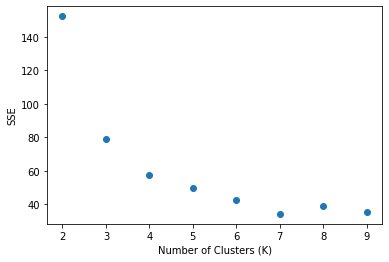

In [14]:
# K = 3, has the elbow formation between 3 & 4 values.
# the elbow formation is what we should look out for
cluster_number = range(2, 10)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.scatter(cluster_number, errors)
plt.show()


In [16]:
silhouette_score = []
for k in range(2, 10):
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(final_data)
    # make predictions
    predictions = model.transform(final_data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_score.append(silhouette)
    print("With K={}".format(k))
    print("silhouette Score = " + str(silhouette))
    print('--'*30)

With K=2
silhouette Score = 0.8501515983265806
------------------------------------------------------------
With K=3
silhouette Score = 0.7354567373091194
------------------------------------------------------------
With K=4
silhouette Score = 0.6711848003790326
------------------------------------------------------------
With K=5
silhouette Score = 0.5617133306478291
------------------------------------------------------------
With K=6
silhouette Score = 0.5036026885690416
------------------------------------------------------------
With K=7
silhouette Score = 0.534396952900366
------------------------------------------------------------
With K=8
silhouette Score = 0.5939622929434096
------------------------------------------------------------
With K=9
silhouette Score = 0.547278582837405
------------------------------------------------------------


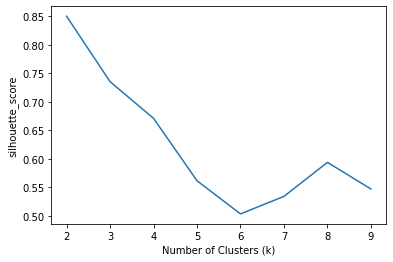

In [17]:
cluster_number = range(2, 10)
plt.plot(cluster_number, silhouette_score)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('silhouette_score')
plt.show()

In [18]:
# the silhouette based clustering evaluation shows the elbow formation at K=3
# so we use K=3
kmeans = KMeans(featuresCol='features', k=3)
model = kmeans.fit(final_data)
model.transform(final_data).groupBy('prediction').count().show()
# this gives us 3 different clustering based on the IRIS ds, although it got some clustering wrong

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   62|
|         2|   38|
|         0|   50|
+----------+-----+



In [20]:
predictions = model.transform(final_data)
# 5 == Label column
predictions.groupBy('5', 'prediction').count().show()
'''
Iris-setosa = 0,
Iris-versicolor = 1,
Iris-virginica = 2,
'''

+---------------+----------+-----+
|              5|prediction|count|
+---------------+----------+-----+
|Iris-versicolor|         2|    2|
|    Iris-setosa|         0|   50|
| Iris-virginica|         1|   14|
| Iris-virginica|         2|   36|
|Iris-versicolor|         1|   48|
+---------------+----------+-----+



In [22]:
pandas_df = predictions.toPandas()
pandas_df.head()

,1,2,3,4,5,features,prediction
0,5.1,3.5,1.4,0.2,Iris-setosa,"[5.1, 3.5, 1.4, 0.2]",0
1,4.9,3.0,1.4,0.2,Iris-setosa,"[4.9, 3.0, 1.4, 0.2]",0
2,4.7,3.2,1.3,0.2,Iris-setosa,"[4.7, 3.2, 1.3, 0.2]",0
3,4.6,3.1,1.5,0.2,Iris-setosa,"[4.6, 3.1, 1.5, 0.2]",0
4,5.0,3.6,1.4,0.2,Iris-setosa,"[5.0, 3.6, 1.4, 0.2]",0


C:\Users\DELL\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


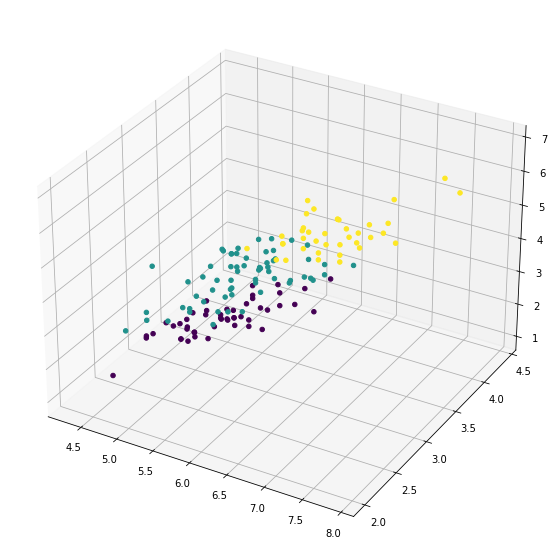

In [25]:
# plot the Clusters in 3D
cluster_vis = plt.figure(figsize=(12, 10)).gca(projection='3d')
cluster_vis.scatter(pandas_df['1'], pandas_df['2'], pandas_df['3'], c=pandas_df.prediction, depthshade=False)
plt.show()

The 3D plot above shows the 3 classes of flowers.